# Building a neural network to predict income from description of a film

Establish connection to drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### SPARQL query to fetch title, description, income of films from dbpedia


SPARQL query to fetch data
```sparql
select distinct ?film ?income ?cat ?desc where {
?film a <http://dbpedia.org/ontology/Film> .
?film <http://dbpedia.org/ontology/gross> ?income .
?film <http://dbpedia.org/ontology/abstract> ?desc .
  {
    ?film <http://purl.org/dc/terms/subject> ?cat . 
    } UNION {
      ?film <http://purl.org/dc/terms/subject> ?scat . 
      ?scat <http://www.w3.org/2004/02/skos/core#broader> ?cat.
  } 
  filter (lang(?desc) = "en")
  filter (lang(?film) = "en")
} group by ?film ?cat ?desc LIMIT 3 OFFSET 100000
```
After doing some requests, I found out that sparql endpoint from dbpedia allows us to get only 10,000 rows at a same time. So, with OFFSET and LIMIT, I managed to get more than 10K entries and I have now a dataset containing 50K rows

## Data understanding

In [1]:
import pandas as pd
import numpy as np

In [2]:
import glob as glob

In [3]:
df = pd.DataFrame()


filepath = ".\data\\" # Local notebook in a data subfolder
# filepath = '.\\' # If using temp files on colab
# filepath = '/content/drive/MyDrive/Cours/Stage/data/' # My drive repo

for filename in glob.glob(filepath + 'data-*.csv'):
    print(f"Concatening {filename} to df...")
    df = pd.concat([df, pd.read_csv(filename)], axis=0)

df.shape

Concatening .\data\data-1.csv to df...
Concatening .\data\data-2.csv to df...
Concatening .\data\data-3.csv to df...
Concatening .\data\data-4.csv to df...
Concatening .\data\data-5.csv to df...


(50000, 4)

In [4]:
df.head()

film     income  \
0  http://dbpedia.org/resource/...All_the_Marbles  6500000.0   
1  http://dbpedia.org/resource/...All_the_Marbles  6500000.0   
2  http://dbpedia.org/resource/...All_the_Marbles  2200000.0   
3  http://dbpedia.org/resource/...All_the_Marbles  2200000.0   
4  http://dbpedia.org/resource/...All_the_Marbles  2200000.0   

                                                 cat  \
0  http://dbpedia.org/resource/Category:Films_sho...   
1  http://dbpedia.org/resource/Category:Films_sho...   
2    http://dbpedia.org/resource/Category:1981_films   
3  http://dbpedia.org/resource/Category:Metro-Gol...   
4  http://dbpedia.org/resource/Category:American_...   

                                                desc  
0  ...All the Marbles (reissued as The California...  
1  ...All the Marbles (reissued as The California...  
2  ...All the Marbles (reissued as The California...  
3  ...All the Marbles (reissued as The California...  
4  ...All the Marbles (reissued as The California...

In [5]:
df.tail()

film       income  \
9995         http://dbpedia.org/resource/The_Family_Man  124700000.0   
9996  http://dbpedia.org/resource/The_Bells_of_St._M...   21333333.0   
9997  http://dbpedia.org/resource/The_French_Connect...   51700000.0   
9998  http://dbpedia.org/resource/The_Toxic_Avenger_...     800000.0   
9999       http://dbpedia.org/resource/The_Tigger_Movie   96200000.0   

                                                    cat  \
9995  http://dbpedia.org/resource/Category:American_...   
9996  http://dbpedia.org/resource/Category:Films_abo...   
9997  http://dbpedia.org/resource/Category:Organized...   
9998  http://dbpedia.org/resource/Category:Horror_fi...   
9999  http://dbpedia.org/resource/Category:2000s_ani...   

                                                   desc  
9995  The Family Man is a 2000 American romantic fan...  
9996  The Bells of St. Mary's (1945) is an American ...  
9997  The French Connection is a 1971 American crime...  
9998  The Toxic Avenger is a 1984 American superhero...  
9999  The Tigger Movie is a 2000 animated musical co...

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   film    50000 non-null  object 
 1   income  50000 non-null  float64
 2   cat     50000 non-null  object 
 3   desc    50000 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.9+ MB


In [7]:
df.describe()

income
count  5.000000e+04
mean   1.029906e+08
std    2.994418e+09
min    3.000000e-02
25%    1.764701e+06
50%    1.000000e+07
75%    5.710000e+07
max    6.640000e+11

In [8]:
df.columns

Index(['film', 'income', 'cat', 'desc'], dtype='object')

In [9]:
df = df.drop_duplicates()
df.shape

(49972, 4)

df = pd.concat([df.groupby("film").mean(), df.groupby('film').nth(0).film, df.groupby('film').nth(0).cat, df.groupby("film").nth(0).desc], axis=1)
df.head()

Creating another dataset to map each film to its related categories

In [10]:
df_cat = pd.concat([df.film, df.cat], axis=1)
df_cat.head()

film  \
0  http://dbpedia.org/resource/...All_the_Marbles   
1  http://dbpedia.org/resource/...All_the_Marbles   
2  http://dbpedia.org/resource/...All_the_Marbles   
3  http://dbpedia.org/resource/...All_the_Marbles   
4  http://dbpedia.org/resource/...All_the_Marbles   

                                                 cat  
0  http://dbpedia.org/resource/Category:Films_sho...  
1  http://dbpedia.org/resource/Category:Films_sho...  
2    http://dbpedia.org/resource/Category:1981_films  
3  http://dbpedia.org/resource/Category:Metro-Gol...  
4  http://dbpedia.org/resource/Category:American_...

Normalizing categories to not have the full link

In [11]:
def normalize_cat(x):
    return "".join(x.split(':')[2])

df_cat['cat_p'] = df_cat['cat'].apply(lambda x: normalize_cat(x))

In [12]:
df_cat.head()

film  \
0  http://dbpedia.org/resource/...All_the_Marbles   
1  http://dbpedia.org/resource/...All_the_Marbles   
2  http://dbpedia.org/resource/...All_the_Marbles   
3  http://dbpedia.org/resource/...All_the_Marbles   
4  http://dbpedia.org/resource/...All_the_Marbles   

                                                 cat  \
0  http://dbpedia.org/resource/Category:Films_sho...   
1  http://dbpedia.org/resource/Category:Films_sho...   
2    http://dbpedia.org/resource/Category:1981_films   
3  http://dbpedia.org/resource/Category:Metro-Gol...   
4  http://dbpedia.org/resource/Category:American_...   

                            cat_p  
0              Films_shot_in_Ohio  
1  Films_shot_in_Youngstown,_Ohio  
2                      1981_films  
3       Metro-Goldwyn-Mayer_films  
4     American_comedy-drama_films

Getting unique films, mean of all the incomes related and unique descriptions

In [13]:
films = df.film.unique()

incomes = []
for f in films:
    incomes.append(df[df.film == f].income.mean())

In [14]:
df_film = pd.DataFrame(films)
df_desc = pd.DataFrame(df.desc.unique())
df_income = pd.DataFrame(incomes)

df_new = pd.DataFrame()
df_new['film'] = df_film
df_new['income'] = df_income
df_new['desc'] = df_desc

df_new.head()

film        income  \
0     http://dbpedia.org/resource/...All_the_Marbles  4.515385e+06   
1  http://dbpedia.org/resource/20,000_Years_in_Si...  9.350000e+05   
2        http://dbpedia.org/resource/ABBA:_The_Movie  5.347122e+06   
3  http://dbpedia.org/resource/A_Christmas_Carol_...  3.250000e+08   
4  http://dbpedia.org/resource/A_Funny_Thing_Happ...  3.400000e+06   

                                                desc  
0  ...All the Marbles (reissued as The California...  
1  20,000 Years in Sing Sing is a 1932 American P...  
2  ABBA: The Movie is a 1977 mocumentary about th...  
3  Disney's A Christmas Carol, or simply A Christ...  
4  A Funny Thing Happened on the Way to the Forum...

In [15]:
df = df_new
df.shape

(14507, 3)

Removing outliers

In [16]:
zscore = (df.income - df.income.mean()) / df.income.std()
dfwo = df[abs(zscore)<2.0]


dfwo=df[df.income < 500000000]
dfwo.describe() 

income
count  1.415000e+04
mean   3.282062e+07
std    7.110414e+07
min    3.000000e-02
25%    1.052332e+06
50%    4.551480e+06
75%    2.579840e+07
max    4.988000e+08

In [17]:
dfwo.shape

(14150, 3)

Visualizing distribution through violinplot

In [18]:
import plotly.express as px

fig = px.violin(dfwo, y="income")
fig.show()

In [19]:
MEDIAN_VALUE = dfwo[dfwo.income < 10000000].income.median()
MEDIAN_VALUE

1500000.0

In [20]:
import matplotlib.pyplot as plt

def plot_range(ar, marker='|'):
  f = plt.figure()
  f.set_figwidth(20)
  f.set_figheight(3)
  val = 0. 
  plt.plot(ar, np.zeros_like(ar) + val, 'x', marker=marker)
  plt.show()

C:\Users\maxim\AppData\Local\Temp/ipykernel_13372/4172125316.py:8: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "x" (-> marker='x'). The keyword argument will take precedence.



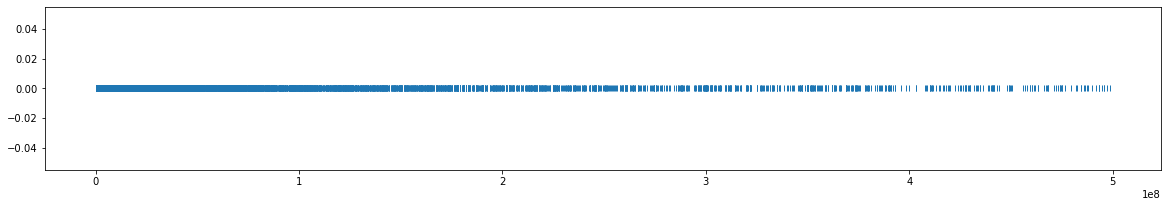

In [21]:
plot_range(np.array(dfwo.income))

## Preprocessing


### Overall data

In [22]:
dfwo.isnull().sum()

film      0
income    0
desc      0
dtype: int64

Creating 3 classes for our NN to classify:
- [< MEDIAN-VALUE] : Medium-Low
- [MEDIAN-VALUE - 10e6] : Medium-High
- [> 10e6] : Exceptional

In [23]:
dfwo.loc[(dfwo.income >= 0), 'income_c'] = 'medium-low'
dfwo.loc[(dfwo.income >= MEDIAN_VALUE), 'income_c'] = 'medium-high'
dfwo.loc[(dfwo.income >= 10e6), 'income_c'] = 'exceptional'
dfwo.head()

D:\users\maxim\anaconda3\envs\rnn-films\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

D:\users\maxim\anaconda3\envs\rnn-films\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



film        income  \
0     http://dbpedia.org/resource/...All_the_Marbles  4.515385e+06   
1  http://dbpedia.org/resource/20,000_Years_in_Si...  9.350000e+05   
2        http://dbpedia.org/resource/ABBA:_The_Movie  5.347122e+06   
3  http://dbpedia.org/resource/A_Christmas_Carol_...  3.250000e+08   
4  http://dbpedia.org/resource/A_Funny_Thing_Happ...  3.400000e+06   

                                                desc     income_c  
0  ...All the Marbles (reissued as The California...  medium-high  
1  20,000 Years in Sing Sing is a 1932 American P...   medium-low  
2  ABBA: The Movie is a 1977 mocumentary about th...  medium-high  
3  Disney's A Christmas Carol, or simply A Christ...  exceptional  
4  A Funny Thing Happened on the Way to the Forum...  medium-high

In [24]:
dfwo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14150 entries, 0 to 14506
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   film      14150 non-null  object 
 1   income    14150 non-null  float64
 2   desc      14150 non-null  object 
 3   income_c  14150 non-null  object 
dtypes: float64(1), object(3)
memory usage: 552.7+ KB


### Text description

Function removing stopwords, links, digits, ...

In [25]:
import string
import re
import nltk
nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words('english')

def clean_text(text):
  text = "".join([word.lower() for word in text if word not in string.punctuation])
  
  # Remove links starting with http
  text1 = re.sub(r'http\S+', ' ', text)

  # Remove digits
  text2 = re.sub(r'\d+', ' ', text1)
  tokens = re.split('\W+', text2)
  text = [word for word in tokens if word not in stopwords+[""]] # MdA: Added the empty string to stopwords

  return text

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


Applying the function to all the DataFrame

In [26]:
dfwo['desc_p'] = dfwo['desc'].apply(lambda x: clean_text(x))
# MdA: created a new column, as otherwise when applied twice it 
# messes things up
dfwo.head()

C:\Users\maxim\AppData\Local\Temp/ipykernel_13372/3004538982.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



film        income  \
0     http://dbpedia.org/resource/...All_the_Marbles  4.515385e+06   
1  http://dbpedia.org/resource/20,000_Years_in_Si...  9.350000e+05   
2        http://dbpedia.org/resource/ABBA:_The_Movie  5.347122e+06   
3  http://dbpedia.org/resource/A_Christmas_Carol_...  3.250000e+08   
4  http://dbpedia.org/resource/A_Funny_Thing_Happ...  3.400000e+06   

                                                desc     income_c  \
0  ...All the Marbles (reissued as The California...  medium-high   
1  20,000 Years in Sing Sing is a 1932 American P...   medium-low   
2  ABBA: The Movie is a 1977 mocumentary about th...  medium-high   
3  Disney's A Christmas Carol, or simply A Christ...  exceptional   
4  A Funny Thing Happened on the Way to the Forum...  medium-high   

                                              desc_p  
0  [marbles, reissued, california, dolls, comedyd...  
1  [years, sing, sing, american, precode, drama, ...  
2  [abba, movie, mocumentary, swedish, pop, group...  
3  [disneys, christmas, carol, simply, christmas,...  
4  [funny, thing, happened, way, forum, britisham...

In [27]:
X = dfwo['desc_p'] # MdA: use the new column
y = dfwo['income_c']

### One-hot encoding on target column

In [28]:
y = pd.get_dummies(y)
y.head()

exceptional  medium-high  medium-low
0            0            1           0
1            0            0           1
2            0            1           0
3            1            0           0
4            0            1           0

### Splitting train & test set

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [30]:
pd.DataFrame(X_test).desc_p.iloc[0]

['naruto',
 'movie',
 'blood',
 'prison',
 'japanese',
 '劇場版',
 'naruto',
 'ナルト',
 'ブラッド',
 'プリズン',
 'hepburn',
 'gekijōban',
 'naruto',
 'buraddo',
 'purizun',
 'japanese',
 'animated',
 'film',
 'based',
 'masashi',
 'kishimotos',
 'manga',
 'anime',
 'series',
 'released',
 'japan',
 'july',
 'north',
 'america',
 'february',
 'indonesia',
 'april',
 'neon',
 'alley',
 'began',
 'streaming',
 'anime',
 'film',
 'january',
 'theme',
 'song',
 'otakebi',
 'performed',
 'yusuke',
 'kamiji',
 'film',
 'follows',
 'ninja',
 'naruto',
 'uzumaki',
 'framed',
 'convicted',
 'crime',
 'intend',
 'commit',
 'sent',
 'prison',
 'hozuki',
 'castle',
 'located',
 'hidden',
 'grass',
 'village',
 'must',
 'escape',
 'find',
 'trustworthy',
 'ally',
 'prove',
 'innocence']

In [31]:
print(X_train.shape)
print(X_test.shape)

(11320,)
(2830,)


In [32]:
print(y_train.shape)
print(y_test.shape)

(11320, 3)
(2830, 3)


### Tokenizing text

In [33]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# The maximum number of words to be used (most frequent)
MAX_NB_WORDS = 10000

# Max number of words in each Tweet
MAX_SEQUENCE_LENGTH = 100

# Intialize and fit the tokenizer
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True, split=' ')
tokenizer.fit_on_texts(X_train)

Transforming into numerical sequences

In [34]:
# Use that tokenizer to transform the text messages in the training and test sets
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

print(X_train[10])
print(X_train_seq[10])

['advance', 'rear', 'lighthearted', 'american', 'western', 'comedy', 'film', 'set', 'american', 'civil', 'war', 'directed', 'george', 'marshall', 'starring', 'glenn', 'ford', 'stella', 'stevens', 'melvyn', 'douglas', 'film', 'based', 'novel', 'company', 'cowards', 'jack', 'schaefer', 'whose', 'inspiration', 'article', 'william', 'chamberlain', 'published', 'saturday', 'evening', 'post', 'chamberlain', 'recounts', 'apocryphal', 'civil', 'war', 'stories', 'company', 'q', 'th', 'century', 'army', 'slang', 'sick', 'list', 'unit', 'composed', 'coward', 'soldiers', 'given', 'second', 'chance', 'prove', 'bravery', 'film', 'novel', 'title', 'preproduction', 'released', 'united', 'kingdom', 'however', 'novel', 'none', 'comedic', 'elements', 'film', 'retained', 'basic', 'idea', 'unit', 'formed', 'men', 'courtmartialed', 'cowardice', 'sent', 'west', 'well', 'character', 'names']
[808, 3, 41, 109, 18, 72, 1, 2, 8287, 1, 278, 123, 45, 160, 130, 145, 46, 12, 74, 2882, 4927, 2253, 999, 292, 383, 87, 

Get max length of a sequence in the DataFrame and the value of the mean + the standard deviation

In [35]:
from statistics import *

def get_max_len(seq):
    max_len = 0
    for x in seq:
        if len(x) > max_len:
            max_len = len(x)
    return max_len

def get_mean_std_len(seq):
    values = []
    for x in seq:
        values.append(len(x))
    
    std = stdev(values)
    m = mean(values)
    return int(m + std)

print(f"Max len: {get_max_len(X_train_seq)}")
print(f"Mean + std: {get_mean_std_len(X_train_seq)}")

Max len: 322
Mean + std: 99


Padding the sequence so each sequence has the same length

In [36]:
# X_train_seq_padded = pad_sequences(X_train_seq, 100)
# X_train_seq_padded = pad_sequences(X_train_seq, 44)
# X_train_seq_padded = pad_sequences(X_train_seq, get_max_len(X_train_seq))
X_train_seq_padded = pad_sequences(X_train_seq, get_mean_std_len(X_train_seq))

# X_test_seq_padded = pad_sequences(X_test_seq, 100)
# X_test_seq_padded = pad_sequences(X_test_seq, 44)
# X_test_seq_padded = pad_sequences(X_test_seq, get_max_len(X_train_seq))
X_test_seq_padded = pad_sequences(X_test_seq, get_mean_std_len(X_train_seq))

X_train_seq_padded[10]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        808,    3,   41,  109,   18,   72,    1,    2, 8287,    1,  278,
        123,   45,  160,  130,  145,   46,   12,   74, 2882, 4927, 2253,
        999,  292,  383,   87, 2883,  122,  166,    1,   77,   70, 8287])

In [37]:
print('X_train_seq_padded:', X_train_seq_padded.shape)
print('X_test_seq_padded:', X_test_seq_padded.shape)

print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

X_train_seq_padded: (11320, 99)
X_test_seq_padded: (2830, 99)
y_train: (11320, 3)
y_test: (2830, 3)


## Model Building

In [39]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, SpatialDropout1D
from tensorflow.keras.optimizers import Adam, RMSprop, Adadelta, Adagrad
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Embedding(input_dim=MAX_NB_WORDS, output_dim=64, input_length=X_train_seq_padded.shape[1]))

# model.add(SpatialDropout1D(0.4))

# Need to activate with tanh and set recurrent_dropout to 0 for the GPU to process
# Initially activation='relu' & recurrent_dropout=0.2
model.add(LSTM(128, activation='tanh', dropout=0.2, recurrent_dropout=0, return_sequences=True, name="lstm_1"))
model.add(LSTM(128, activation='tanh', dropout=0.2, recurrent_dropout=0, return_sequences=True, name="lstm_2"))
model.add(LSTM(128, activation='tanh', dropout=0.2, recurrent_dropout=0, name="lstm_3"))

model.add(Dense(64, activation='relu')) 

# model.add(Dropout(0.4))

model.add(Dense(3, activation='softmax')) 


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 99, 64)            640000    
                                                                 
 lstm_1 (LSTM)               (None, 99, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 99, 128)           131584    
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 1,010,435
Trainable params: 1,010,435
Non-

optimizers : https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
- https://deepdatascience.wordpress.com/2016/11/18/which-lstm-optimizer-to-use/
-https://deepdatascience.files.wordpress.com/2016/11/contours_evaluation_optimizers.gif?w=616
- https://deepdatascience.files.wordpress.com/2016/11/saddle_point_evaluation_optimizers.gif?w=616

loss fns : https://www.tensorflow.org/api_docs/python/tf/keras/losses

metrics : https://www.tensorflow.org/api_docs/python/tf/keras/metrics

Compile the model

In [ ]:
# model.compile(optimizer=Adam(learning_rate=0.0001, clipnorm=0.001, clipvalue=0.5), loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=RMSprop(learning_rate=0.0001, clipnorm=0.001, clipvalue=0.5), loss='categorical_crossentropy', metrics=['accuracy'])

# Adding an early stopping
es = EarlyStopping(monitor='val_accuracy', 
                   mode='max', 
                   patience=3, #Stop the model training if the validation accuracy doesnt increase in 3 consecutive Epochs
                   restore_best_weights=True)

In [ ]:
BATCH_SIZE = 64
EPOCHS = 30

Fit the RNN

In [ ]:
# For the GPU training
with tf.device('/device:GPU:0'):
    history = model.fit(X_train_seq_padded, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_test_seq_padded, y_test))
  
# history = model.fit(X_train_seq_padded, y_train, batch_size=BATCH_SIZE, callbacks=[es], 
#                     epochs=EPOCHS, validation_data=(X_test_seq_padded, y_test))

Epoch 1/30
177/177 [==============================] - 15s 43ms/step - loss: 1.0307 - accuracy: 0.4708 - val_loss: 1.0039 - val_accuracy: 0.4799
Epoch 2/30
177/177 [==============================] - 6s 35ms/step - loss: 0.9472 - accuracy: 0.5178 - val_loss: 0.9409 - val_accuracy: 0.5194
Epoch 3/30
177/177 [==============================] - 6s 35ms/step - loss: 0.8867 - accuracy: 0.5553 - val_loss: 0.9193 - val_accuracy: 0.5488
Epoch 4/30
177/177 [==============================] - 6s 35ms/step - loss: 0.8425 - accuracy: 0.5851 - val_loss: 0.8963 - val_accuracy: 0.5590
Epoch 5/30
177/177 [==============================] - 6s 35ms/step - loss: 0.8062 - accuracy: 0.6148 - val_loss: 0.8885 - val_accuracy: 0.5770
Epoch 6/30
177/177 [==============================] - 7s 42ms/step - loss: 0.7724 - accuracy: 0.6420 - val_loss: 0.8994 - val_accuracy: 0.5809
Epoch 7/30
177/177 [==============================] - 12s 65ms/step - loss: 0.7423 - accuracy: 0.6612 - val_loss: 0.9026 - val_accuracy: 0.57

(optional) Save the model

In [ ]:
model.save('./rnn-3')

INFO:tensorflow:Assets written to: ./rnn-3\assets


INFO:tensorflow:Assets written to: ./rnn-3\assets


Might be overfitting https://datascience.stackexchange.com/questions/97132/my-lstm-has-a-really-low-accuracy-is-there-anyway-to-improve-it

Ways to reduce overfitting:
- use more data
- Add dropout layer
- reduce the number of neurons at each layer of the model
- use a different metric rather than **accuracy**
- use **batch normalization** instead of **Dropout**

Other theory is : **Exploding gradient** and could be resolved with **gradient clipping**

https://machinelearningmastery.com/exploding-gradients-in-neural-networks/

So, maybe use a smaller batch size ??

"In the Keras deep learning library, you can use gradient clipping by setting the clipnorm or clipvalue arguments on your optimizer before training. Good default values are **clipnorm=1.0** and **clipvalue=0.5**."

## Model Evaluation

#### Plotting model performance
Get values of accuracy, val_accuracy, loss and val_loss to plot them

In [ ]:
import plotly.express as px

def plot_acc_loss():
  
  h = history.history

  df_acc = pd.DataFrame()
  df_acc["acc"] = h['accuracy']
  df_acc["val_acc"] = h['val_accuracy']

  df_loss = pd.DataFrame()

  df_loss["loss"] = h['loss']
  df_loss["val_loss"] = h['val_loss']

  fig = px.line(df_acc, title='Accuracy of the model', labels = {'index': "Epoch"}, width=800, height=400)
  fig.show()

  fig = px.line(df_loss, title='Loss of the model', labels = {'index': "Epoch"}, width=800, height=400)
  fig.show()

In [ ]:
plot_acc_loss()

In [ ]:
score = model.evaluate(X_test_seq_padded, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.269051194190979
Test accuracy: 0.5600706934928894


In [ ]:
y_test

exceptional  medium-high  medium-low
736              1            0           0
3366             0            0           1
4113             1            0           0
14030            1            0           0
1080             0            1           0
...            ...          ...         ...
5617             1            0           0
11156            1            0           0
110              0            1           0
9141             0            0           1
3093             1            0           0

[2830 rows x 3 columns]

#### Confusion Matrix

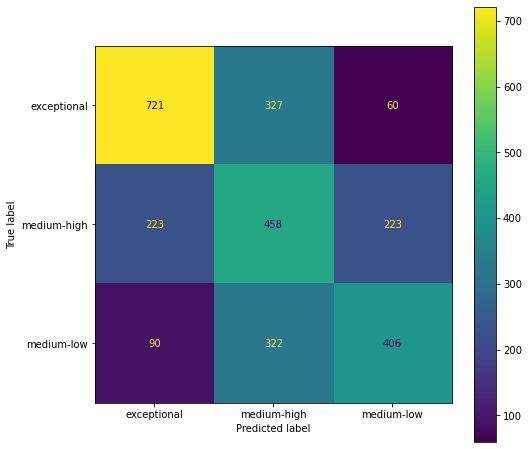

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,8))

y_pred = model.predict(X_test_seq_padded) # MdA: get the predictions for X_test

# MdA: show the confusion matrix
y_pred_r = np.argmax(y_pred, axis=1)
y_test_r = np.argmax(np.array(y_test), axis=1)
matrix = confusion_matrix(y_test_r,y_pred_r)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=["exceptional","medium-high","medium-low"])
disp.plot(ax=ax)

In [ ]:
model.optimizer.learning_rate, model.optimizer.clipnorm, model.optimizer.clipvalue

(<tf.Variable 'RMSprop/learning_rate:0' shape=() dtype=float32, numpy=1e-04>,
 0.001,
 0.5)

## To load the model

In [38]:
from tensorflow import keras
# model_loaded = keras.models.load_model("/content/drive/MyDrive/Cours/Stage/models/rnn-3")
model_loaded = keras.models.load_model("./rnn-3")
model_loaded

**ERASE THE PREVIOUS MODEL**

In [39]:
model = model_loaded

# Visualize and understand neuron activations

In [40]:
list(map(lambda x: x.name, model.layers))

['embedding_2', 'lstm_1', 'lstm_2', 'lstm_3', 'dense_4', 'dense_5']

### Re-creating second model 
Re-creating second model identical from the one trained but removing the last dense layer to collect activations values

In [41]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 99, 64)            640000    
                                                                 
 lstm_1 (LSTM)               (None, 99, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 99, 128)           131584    
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 3)                 195       
                                                                 
Total params: 1,010,435
Trainable params: 1,010,435
No

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout

In [43]:
model2 = Sequential()
model2.add(Embedding(input_dim=MAX_NB_WORDS, output_dim=64, input_length=X_train_seq_padded.shape[1], weights=model.layers[0].get_weights()))

activations_embedding = model2.predict(X_test_seq_padded)
activations_embedding.shape

(2830, 99, 64)

In [44]:
for i, layer in enumerate(model.layers):
  print(i, layer.name)

0 embedding_2
1 lstm_1
2 lstm_2
3 lstm_3
4 dense_4
5 dense_5


In [45]:
model2 = Sequential()
model2.add(Embedding(input_dim=MAX_NB_WORDS, output_dim=64, input_length=X_train_seq_padded.shape[1], weights=model.layers[0].get_weights()))

model2.add(LSTM(128, activation='tanh', dropout=0.2, recurrent_dropout=0, return_sequences=True, name="lstm_1", weights=model.layers[1].get_weights()))
model2.add(LSTM(128, activation='tanh', dropout=0.2, recurrent_dropout=0, return_sequences=True, name="lstm_2", weights=model.layers[2].get_weights()))
model2.add(LSTM(128, activation='tanh', dropout=0.2, recurrent_dropout=0, name="lstm_3", weights=model.layers[3].get_weights()))

model2.add(Dense(64, activation='relu', weights=model.layers[4].get_weights())) 

In [46]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 99, 64)            640000    
                                                                 
 lstm_1 (LSTM)               (None, 99, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 99, 128)           131584    
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
Total params: 1,010,240
Trainable params: 1,010,240
Non-trainable params: 0
_________________________________________________________________


In [ ]:
activations = model2.predict(X_test_seq_padded)
activations

In [54]:
activations.T.shape

(64, 2830)

In [55]:
activations.shape

(2830, 64)

In [ ]:
pd.DataFrame(activations).describe()

0            1            2            3            4   \
count  2830.000000  2830.000000  2830.000000  2830.000000  2830.000000   
mean      0.355619     0.235758     0.559205     0.207426     0.284328   
std       0.255920     0.343341     0.423158     0.296764     0.285582   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.073329     0.000000     0.302947     0.000000     0.000000   
50%       0.398832     0.039796     0.481393     0.120110     0.243648   
75%       0.571307     0.378467     0.654996     0.278580     0.547485   
max       0.886352     1.472948     2.071621     1.363092     1.002289   

                5            6            7            8            9   ...  \
count  2830.000000  2830.000000  2830.000000  2830.000000  2830.000000  ...   
mean      0.399982     0.117783     0.177490     0.350166     0.076661  ...   
std       0.629517     0.180072     0.195581     0.500936     0.143593  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
50%       0.069103     0.000000     0.116653     0.014843     0.000000  ...   
75%       0.546973     0.204080     0.313522     0.593872     0.097840  ...   
max       2.640908     0.872634     0.867110     1.642031     0.869898  ...   

                54           55           56           57           58  \
count  2830.000000  2830.000000  2830.000000  2830.000000  2830.000000   
mean      0.523695     0.185967     0.362455     0.112110     0.445629   
std       0.385327     0.331775     0.508406     0.194806     0.367112   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.092455     0.000000     0.000000     0.000000     0.047923   
50%       0.577611     0.000000     0.069387     0.000000     0.459285   
75%       0.833211     0.259215     0.568254     0.171383     0.739159   
max       1.429824     1.734121     1.647988     1.057525     1.224110   

                59           60           61           62           63  
count  2830.000000  2830.000000  2830.000000  2830.000000  2830.000000  
mean      0.526015     0.984269     0.465866     0.610483     0.106046  
std       0.460945     0.582794     0.610474     0.393749     0.178469  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.605759     0.064959     0.367593     0.000000  
50%       0.574480     1.000625     0.235109     0.507303     0.000000  
75%       0.924733     1.281330     0.548395     0.701780     0.165542  
max       1.700340     2.562061     2.475317     1.964280     0.893992  

[8 rows x 64 columns]

In [ ]:
activations[0].shape

(64,)

Creating DataFrame containing neurons and activations values for each neuron

In [ ]:
def get_activation_matrix(activations):
    df_dict = {
        'value': [],
        'neuron_index': []
    }

    # MH: transpose the matrix to have neurons as index
    for neuron_index, value_list in enumerate(activations.T):
      # print(neuron_index, value_list)
      for value in value_list:
        df_dict['value'].append(value)
        df_dict['neuron_index'].append(neuron_index + 1) # MH: Should we let first neuron at 0 ?
      # print(neuron_index)

    df_act = pd.DataFrame().from_dict(df_dict)
    return df_act

In [ ]:
# Get the list of distinct categories
def get_unique_cats():
    cat_length = []
    for cat in df_cat.cat_p.unique():
        cat_length.append((cat, df_cat[df_cat.cat_p == cat].shape[0]))
    return cat_length

# Get categories which number of films associated is greater (or equal) than
# a given value
# Issue : this fn is getting cats from the whole cat dict but these cats may
# not be comprised in the X_test
def get_cats_greater_or_equal_than(value):
    cats = []
    for l in get_unique_cats():
        cat, n = l
        if n >= value:
            cats.append((cat, n))
    return cats


In [58]:
# Return the list of activations (list) related to a given category
def get_activations_for_cat(category):
    activations = []
    for i in range(len(df_cat_act.cat)):
        if category in df_cat_act.cat.iloc[i]:
#             print(df_cat_act.cat.iloc[i], i)
            activations.append(df_cat_act.activation.iloc[i])
    return np.array(activations)

def get_activations_for_seq(model, seq, full_seq, X_test):
    activations = model.predict(full_seq)
    for i in range(3): #(len(X_test)):
        print(pd.DataFrame(X_test).desc_p.iloc[i], seq)
        # if pd.DataFrame(X_test).desc_p == seq:
        #   index = i
        #   return activations[i]
    # return None # pd.DataFrame()


# get_activations_for_seq(model2, X_test_seq_padded[0], X_test_seq_padded, X_test)
def get_seq_padded_index(seq):
    for i in range(len(X_test_seq_padded)):
        if X_test_seq_padded[i].any() == seq.any():
            return i, X_test_seq_padded, seq
    return None

get_seq_padded_index(X_test_seq_padded[1568])

(0, array([[   0,    0,    0, ..., 5225, 3871, 3089],
        [   0,    0,    0, ...,  195,  220,  321],
        [   0,    0,  819, ...,   43,    1,   30],
        ...,
        [   0,    0,    0, ..., 1980,  257, 3760],
        [   0,    0,    0, ...,   84, 2995, 2679],
        [   0,    0,    0, ...,  312,   63,   10]], dtype=int32), array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    3,   13,    1,
           2,  303, 4960,    6, 4112, 2764,  619,  856,  195, 7683,  134

In [ ]:
# We get all the films for a given category
def get_films_from_cat(cat):
    return df_cat[df_cat.cat_p == cat]

# Then we get categories from the film uri
def get_cats_from_film(film):
    cats= []
    fetch_cats = df_cat[df_cat.film == film].cat_p.unique()
    for cat in fetch_cats:
        cats.append(cat)
        
    return cats

# Upper function which gets categories for a given sequence
def get_cats_from_seq(seq):
    return get_cats_from_film(get_film_from_seq(seq).film)

def get_film_index(film):
    for i in range(len(X_test)): # X_test
        if X_test.iloc[i] == film.desc_p:
            return i
    return None

In [ ]:
cats = get_cats_greater_or_equal_than(50)
cats

[('Metro-Goldwyn-Mayer_films', 152),
 ('American_comedy-drama_films', 76),
 ('British_films', 243),
 ('Paramount_Pictures_films', 120),
 ('American_films', 1430),
 ('Films_shot_in_California', 82),
 ('English-language_films', 934),
 ('American_comedy_films', 61),
 ('Films_based_on_American_novels', 172),
 ('American_black-and-white_films', 221),
 ('Cantonese-language_films', 74),
 ('Chinese_films', 70),
 ('Columbia_Pictures_films', 101),
 ('American_drama_films', 187),
 ('Films_shot_in_New_York_City', 87),
 ('20th_Century_Fox_films', 149),
 ('American_LGBT-related_films', 53),
 ('Universal_Pictures_films', 114),
 ('2000s_English-language_films', 80),
 ('2002_films', 56),
 ('American_romantic_drama_films', 81),
 ('American_romantic_comedy_films', 121),
 ('2003_films', 51),
 ('Films_shot_in_Los_Angeles', 146),
 ('American_independent_films', 172),
 ('American_crime_drama_films', 68),
 ('2010_films', 95),
 ('Films_set_in_London', 97),
 ('2010s_English-language_films', 62),
 ('Films_set_in

**Other intuition** : start by getting film from the category and then filter

In [ ]:
get_films_from_cat('American_comedy_films_by_genre')

film  \
9819  http://dbpedia.org/resource/John_Dies_at_the_E...   
9964  http://dbpedia.org/resource/Super_Mario_Bros._...   
100           http://dbpedia.org/resource/Willow_(film)   
563   http://dbpedia.org/resource/Don't_Tell_Mom_the...   
645     http://dbpedia.org/resource/Multiplicity_(film)   
725   http://dbpedia.org/resource/The_Princess_Diari...   
926   http://dbpedia.org/resource/Bachelor_Party_(19...   
946              http://dbpedia.org/resource/Girl_Happy   
1245       http://dbpedia.org/resource/Enchanted_(film)   
1338  http://dbpedia.org/resource/What_Planet_Are_Yo...   
1894          http://dbpedia.org/resource/Seven_Chances   
2012  http://dbpedia.org/resource/School_for_Scoundr...   
2234  http://dbpedia.org/resource/Return_of_the_Livi...   
2377             http://dbpedia.org/resource/The_TV_Set   
2734     http://dbpedia.org/resource/Company_Man_(film)   
2482  http://dbpedia.org/resource/Super_(2010_Americ...   
2632       http://dbpedia.org/resource/Dave_Made_a_Maze   
2661  http://dbpedia.org/resource/Take_Me_Out_to_the...   
2765          http://dbpedia.org/resource/Lilo_&_Stitch   
3025           http://dbpedia.org/resource/Ellie_Parker   
3074  http://dbpedia.org/resource/Alvin_and_the_Chip...   
3976  http://dbpedia.org/resource/I_Could_Never_Be_Y...   
4223  http://dbpedia.org/resource/Father_of_the_Brid...   
4412  http://dbpedia.org/resource/Bewitched_(2005_film)   
4619      http://dbpedia.org/resource/How_to_Rob_a_Bank   
4804          http://dbpedia.org/resource/Way...Way_Out   
5154   http://dbpedia.org/resource/Fritz_the_Cat_(film)   
5534    http://dbpedia.org/resource/Tempest_(1982_film)   
5544  http://dbpedia.org/resource/Young_Doctors_in_Love   
6026         http://dbpedia.org/resource/Miami_Rhapsody   
6047        http://dbpedia.org/resource/Spaced_Invaders   
6513  http://dbpedia.org/resource/Bullets_Over_Broadway   
6607               http://dbpedia.org/resource/Sideways   
7109         http://dbpedia.org/resource/Happy_Feet_Two   
7266  http://dbpedia.org/resource/Jay_and_Silent_Bob...   
7456           http://dbpedia.org/resource/Corpse_Bride   
7482   http://dbpedia.org/resource/Fandango_(1985_film)   
7632                   http://dbpedia.org/resource/F/X2   
7733         http://dbpedia.org/resource/Up_the_Sandbox   
7890  http://dbpedia.org/resource/The_Family_That_Preys   
8157  http://dbpedia.org/resource/Code_Name:_The_Cle...   
8243  http://dbpedia.org/resource/How_to_Talk_to_Gir...   
8465     http://dbpedia.org/resource/Familiar_Strangers   
8467  http://dbpedia.org/resource/Let_It_Snow_(2001_...   
8207              http://dbpedia.org/resource/Hall_Pass   
8227              http://dbpedia.org/resource/Man-Proof   
8329  http://dbpedia.org/resource/Diary_of_a_Wimpy_K...   
8353  http://dbpedia.org/resource/The_War_of_the_Ros...   
8354             http://dbpedia.org/resource/Ted_(film)   
8561         http://dbpedia.org/resource/The_Great_Race   
9283       http://dbpedia.org/resource/Multiple_Maniacs   
9390     http://dbpedia.org/resource/Herbie_Rides_Again   
9483  http://dbpedia.org/resource/Throw_Momma_from_t...   
9745     http://dbpedia.org/resource/A_Man_Called_Sarge   

                                                    cat  \
9819  http://dbpedia.org/resource/Category:American_...   
9964  http://dbpedia.org/resource/Category:American_...   
100   http://dbpedia.org/resource/Category:American_...   
563   http://dbpedia.org/resource/Category:American_...   
645   http://dbpedia.org/resource/Category:American_...   
725   http://dbpedia.org/resource/Category:American_...   
926   http://dbpedia.org/resource/Category:American_...   
946   http://dbpedia.org/resource/Category:American_...   
1245  http://dbpedia.org/resource/Category:American_...   
1338  http://dbpedia.org/resource/Category:American_...   
1894  http://dbpedia.org/resource/Category:American_...   
2012  http://dbpedia.org/resource/Category:American_...   
2234  http://dbpedia.org/resource/Cate

In [ ]:
get_film_from_seq(X_test.iloc[0]).film

'http://dbpedia.org/resource/Naruto_the_Movie:_Blood_Prison'

In [ ]:
get_film_index(get_film_from_seq(X_test.iloc[0]))

0

In [ ]:
df_act = get_activation_matrix(activations)
df_act.head()

value  neuron_index
0  0.171008             1
1  0.727569             1
2  0.000000             1
3  0.000000             1
4  0.477308             1

In [ ]:
df_act.describe()

value   neuron_index
count  181120.000000  181120.000000
mean        0.309049      32.500000
std         0.428413      18.473004
min         0.000000       1.000000
25%         0.000000      16.750000
50%         0.127959      32.500000
75%         0.486979      48.250000
max         3.041667      64.000000

### Visualizing activation values over each neuron

In [ ]:
def plot_activations(activations, title="Activation values"):
    fig = px.scatter(activations, x='neuron_index', y='value', 
           title=title, labels={'neuron_index': 'Neuron', 'value': 'Value'})
    fig.show()

In [ ]:
plot_activations(df_act, "Activation values per neuron (first dense layer)")

# Loading categories

In [ ]:
model2.predict(X_test_seq_padded)

array([[0.1710083 , 0.10230751, 0.        , ..., 0.13118814, 0.28867856,
        0.        ],
       [0.7275689 , 0.        , 0.5964481 , ..., 0.14169303, 0.5846515 ,
        0.15057713],
       [0.        , 0.79528   , 1.291138  , ..., 1.7050183 , 1.273891  ,
        0.        ],
       ...,
       [0.58732486, 0.        , 0.36398333, ..., 0.05682675, 0.2930678 ,
        0.39467606],
       [0.44921103, 0.        , 0.4634463 , ..., 0.14919701, 0.3351716 ,
        0.20743667],
       [0.142538  , 0.23285957, 0.34963706, ..., 0.29821923, 0.59789014,
        0.        ]], dtype=float32)

In [ ]:
pd.DataFrame(X_test)

desc_p
736    [naruto, movie, blood, prison, japanese, 劇場版, ...
3366   [snow, walker, canadian, survival, drama, film...
4113   [bear, french, adventure, drama, family, film,...
14030  [fist, fight, american, comedy, film, directed...
1080   [charly, marketed, stylized, chaяly, american,...
...                                                  ...
5617   [labor, day, american, drama, film, written, d...
11156  [everybodys, allamerican, american, sports, dr...
110    [upon, honeymoon, romantic, comedydrama, starr...
9141   [listen, marlon, british, documentary, film, w...
3093   [woody, woodpecker, also, known, woody, woodpe...

[2830 rows x 1 columns]

In [ ]:
df_cat.head()

film  \
0  http://dbpedia.org/resource/...All_the_Marbles   
1  http://dbpedia.org/resource/...All_the_Marbles   
2  http://dbpedia.org/resource/...All_the_Marbles   
3  http://dbpedia.org/resource/...All_the_Marbles   
4  http://dbpedia.org/resource/...All_the_Marbles   

                                                 cat  \
0  http://dbpedia.org/resource/Category:Films_sho...   
1  http://dbpedia.org/resource/Category:Films_sho...   
2    http://dbpedia.org/resource/Category:1981_films   
3  http://dbpedia.org/resource/Category:Metro-Gol...   
4  http://dbpedia.org/resource/Category:American_...   

                            cat_p  
0              Films_shot_in_Ohio  
1  Films_shot_in_Youngstown,_Ohio  
2                      1981_films  
3       Metro-Goldwyn-Mayer_films  
4     American_comedy-drama_films

In [ ]:
df_cat.describe()

film  \
count                                             49972   
unique                                            14507   
top     http://dbpedia.org/resource/The_Tin_Drum_(film)   
freq                                                 42   

                                                      cat           cat_p  
count                                               49972           49972  
unique                                              13090           13089  
top     http://dbpedia.org/resource/Category:American_...  American_films  
freq                                                 1430            1430

In [ ]:
df_cat.shape

(49972, 3)

Number of distinct categories we have

In [ ]:
df_cat.cat.unique().shape

(13090,)

In [ ]:
activations.shape

(2830, 64)

Shape of the sequence we'll be re-using later

In [ ]:
X_test.shape

(2830,)

## Search for films and categories related to a given activation

Creating dict of activations associated to categories

In [ ]:
dict_cat_act = {
    'cat': [],
    'activation': []
}

for i in range(len(activations)):
    dict_cat_act['cat'].append(get_cats_from_seq(X_test.iloc[i]))
    dict_cat_act['activation'].append(activations[i])

df_cat_act = pd.DataFrame.from_dict(dict_cat_act)
df_cat_act.head()

cat  \
0  [2011_anime_films, Films_directed_by_Masahiko_...   
1  [English-language_films, Lionsgate_films, Cana...   
2  [Films_set_in_British_Columbia, European_films...   
3                            [New_Line_Cinema_films]   
4  [1968_drama_films, Human_experimentation_in_fi...   

                                          activation  
0  [0.1710083, 0.102307506, 0.0, 0.0, 0.0, 0.0998...  
1  [0.7275689, 0.0, 0.5964481, 0.20888972, 0.6633...  
2  [0.0, 0.79528, 1.291138, 0.6526262, 0.0, 1.437...  
3  [0.0, 0.4188319, 0.22354153, 0.0, 0.0, 0.74053...  
4  [0.47730818, 0.07789885, 0.015860274, 0.0, 0.0...

Sample use of getting activations for a given category

In [ ]:
get_activations_for_cat('Metro-Goldwyn-Mayer_films')

array([[2.7836338e-01, 2.1260928e-01, 2.9163933e-01, ..., 1.5657254e-01,
        4.7303116e-01, 0.0000000e+00],
       [6.4879233e-01, 0.0000000e+00, 4.1688573e-01, ..., 1.2777196e-03,
        3.8411880e-01, 2.3449694e-01],
       [0.0000000e+00, 3.2625982e-01, 2.0038374e-01, ..., 4.1235694e-01,
        4.5394492e-01, 0.0000000e+00],
       ...,
       [4.0728179e-01, 0.0000000e+00, 4.9933067e-01, ..., 2.0361814e-01,
        3.4771806e-01, 1.8134934e-01],
       [0.0000000e+00, 6.3963026e-01, 1.1119483e+00, ..., 1.5835844e+00,
        1.3274808e+00, 0.0000000e+00],
       [3.8780564e-01, 3.5283369e-01, 5.5058390e-01, ..., 4.2735142e-01,
        7.0178515e-01, 0.0000000e+00]], dtype=float32)

Then plot activations for this category

In [ ]:
plot_activations(get_activation_matrix(get_activations_for_cat('Metro-Goldwyn-Mayer_films')), 
                 f"Activation values for Metro-Goldwyn-Mayer_films")

Getting most popular categories (n >= 200)

In [ ]:
popular_categories = get_cats_greater_or_equal_than(200)

 ## Plot activations for all the most popular categories

In [ ]:
def plot_activation_for_categories(categories):
    for cat in categories:
        _cat = cat[0]
        df_sample = get_activation_matrix(get_activations_for_cat(_cat))
        plot_activations(df_sample, f"Activations values for category: {_cat}")


In [ ]:
df_test = get_activation_matrix(get_activations_for_cat('Metro-Goldwyn-Mayer_films'))
df_test

value  neuron_index
0     0.278363             1
1     0.648792             1
2     0.000000             1
3     0.649532             1
4     0.191186             1
...        ...           ...
1979  0.000000            64
1980  0.000000            64
1981  0.181349            64
1982  0.000000            64
1983  0.000000            64

[1984 rows x 2 columns]

In [ ]:
def get_mean_activation_matrix(category):
    means = []
    _df_cat = get_activation_matrix(get_activations_for_cat(category))
    for i in range(1, 64 + 1):
        means.append(_df_cat[_df_cat.neuron_index == i].value.mean())

    return means

def plot_mean_activations_for_category(categories):
    for cat in categories:
        _cat = cat[0]
        df_sample = get_mean_activation_matrix(_cat)
        fig = px.scatter(df_sample, title=f"Mean activation values for {_cat}")
        fig.show()

In [ ]:
means = []
for i in range(1, 64 + 1):
    means.append(df_test[df_test.neuron_index == i].value.mean())
    # print(i, ":", df_test[df_test.neuron_index == i].value.mean())

px.scatter(means, title="Mean activation per each neuron for category 'Metro-Goldwyn-Mayer_films'")

In [ ]:
len(get_activations_for_cat('Metro-Goldwyn-Mayer_films'))

31

In [ ]:
get_activation_matrix_per_neuron(get_activations_for_cat('Metro-Goldwyn-Mayer_films'))

1         2         3         4         5         6         7  \
0   0.278363  0.212609  0.291639  0.000000  0.000000  0.082864  0.000000   
1   0.648792  0.000000  0.416886  0.222074  0.687947  0.000000  0.248661   
2   0.000000  0.326260  0.200384  0.000000  0.000000  0.479772  0.000000   
3   0.649532  0.000000  0.430128  0.247717  0.642803  0.000000  0.302795   
4   0.191186  0.134894  0.016363  0.000000  0.000000  0.123627  0.000000   
5   0.472841  0.000000  0.435307  0.286332  0.540118  0.000000  0.255333   
6   0.421914  0.000000  0.581405  0.210973  0.406405  0.011248  0.118159   
7   0.730858  0.000000  0.220211  0.318736  0.838437  0.000000  0.500187   
8   0.676332  0.000000  0.250446  0.331871  0.768733  0.000000  0.470012   
9   0.662671  0.000000  0.262898  0.318948  0.620927  0.000000  0.512989   
10  0.540365  0.000000  0.403018  0.130445  0.528147  0.000000  0.159086   
11  0.600486  0.000000  0.426111  0.286836  0.618825  0.000000  0.337364   
12  0.608556  0.000000  0.525618  0.259504  0.575067  0.000000  0.269018   
13  0.291988  0.039676  0.542173  0.099401  0.255453  0.187378  0.000000   
14  0.113464  0.394426  0.392999  0.000000  0.000000  0.438186  0.000000   
15  0.584126  0.000000  0.636701  0.109009  0.494814  0.000000  0.062860   
16  0.716771  0.000000  0.809877  0.000000  0.488692  0.000000  0.000000   
17  0.596721  0.000000  0.267799  0.310789  0.685064  0.000000  0.412205   
18  0.000000  0.524043  0.757869  0.105563  0.000000  1.064618  0.000000   
19  0.731265  0.000000  0.134282  0.370752  0.811934  0.000000  0.611413   
20  0.616973  0.000000  0.947170  0.103074  0.434012  0.121474  0.000000   
21  0.000000  0.753991  1.319006  0.698693  0.000000  1.506004  0.000000   
22  0.240113  0.300736  0.663192  0.000000  0.024092  0.359470  0.000000   
23  0.418890  0.017059  0.655195  0.108835  0.366810  0.104521  0.000000   
24  0.126369  0.324375  0.373217  0.000000  0.000000  0.314149  0.000000   
25  0.666225  0.000000  0.495067  0.234879  0.654440  0.000000  0.242293   
26  0.385277  0.052799  0.738632  0.125996  0.325677  0.181156  0.000000   
27  0.000000  0.404137  0.212548  0.000000  0.000000  0.562992  0.000000   
28  0.407282  0.000000  0.499331  0.275607  0.434537  0.000000  0.224952   
29  0.000000  0.639630  1.111948  0.418929  0.000000  1.410077  0.000000   
30  0.387806  0.352834  0.550584  0.000000  0.000000  0.347247  0.000000   

           8         9        10  ...        55        56        57        58  \
0   0.179210  0.243746  0.000000  ...  0.588339  0.000000  0.154289  0.000000   
1   0.311055  0.000000  0.101376  ...  0.878950  0.328563  0.000000  0.240401   
2   0.002266  0.550012  0.000000  ...  0.014175  0.000000  0.464717  0.000000   
3   0.333279  0.000000  0.175901  ...  0.858748  0.497267  0.000000  0.257136   
4   0.221390  0.283591  0.000000  ...  0.308143  0.000000  0.130813  0.000000   
5   0.223375  0.000000  0.179587  ...  0.669096  0.449977  0.000000  0.219324   
6   0.064254  0.000000  0.043179  ...  0.568216  0.159599  0.000753  0.002301   
7   0.536581  0.000000  0.322590  ...  1.034942  0.848565  0.000000  0.535736   
8   0.498504  0.000000  0.327291  ...  0.934047  0.838284  0.000000  0.498038   
9   0.504836  0.000000  0.444630  ...  0.914260  0.992443  0.000000  0.512737   
10  0.169062  0.000000  0.041009  ...  0.714128  0.041490  0.000000  0.085606   
11  0.352269  0.000000  0.228687  ...  0.824382  0.633427  0.000000  0.293509   
12  0.289617  0.000000  0.154821  ...  0.812603  0.498147  0.000000  0.196351   
13  0.000000  0.078841  0.000000  ...  0.371979  0.000000  0.158569  0.000000   
14  0.000000  0.552560  0.000000  ...  0.200688  0.000000  0.452326  0.000000   
15  0.106957  0.000000  0.000000  ...  0.779003  0.000000  0.000000  0.000000   
16  0.283400  0.000000  0.000000  ...  1.188583  0.000000  0.000000  0.000000   
17  0.412062  0.000000  0.311291  ...  0.830968  0.723438  0.000000  0.422723   
18  0.000000  1.112084  0.000000  ...  

We can have a boxplot on activations for this category

In [ ]:
px.box(get_activation_matrix_per_neuron(get_activations_for_cat('Metro-Goldwyn-Mayer_films')))

## Store activations
Store activations into a csv file to re-use it in a different notebook for cleaner code

In [ ]:
import os

get_activation_matrix_per_neuron(activations).to_csv("/content/drive/MyDrive/Cours/Stage/data/activations.csv", index=False)

In [ ]:
pd.read_csv('/content/drive/MyDrive/Cours/Stage/data/activations.csv').shape

(2830, 64)

In [49]:
activations = model2.predict(X_test_seq_padded)
activations

array([[0.17100824, 0.10230751, 0.        , ..., 0.13118814, 0.28867862,
        0.        ],
       [0.72756886, 0.        , 0.5964481 , ..., 0.14169301, 0.5846514 ,
        0.15057726],
       [0.        , 0.7952803 , 1.2911383 , ..., 1.7050185 , 1.2738911 ,
        0.        ],
       ...,
       [0.5873247 , 0.        , 0.36398327, ..., 0.05682668, 0.2930678 ,
        0.39467603],
       [0.44921094, 0.        , 0.46344632, ..., 0.14919703, 0.33517164,
        0.20743665],
       [0.14253801, 0.23285961, 0.3496371 , ..., 0.29821938, 0.5978902 ,
        0.        ]], dtype=float32)

In [50]:
activations.shape, activations.T.shape

((2830, 64), (64, 2830))

In [51]:
def get_film_from_seq_desc(seq_desc):
    for i in range(len(dfwo.desc_p)):
        if dfwo.desc_p.iloc[i] == seq_desc:
            return dfwo.iloc[i] # added [0]
    return pd.DataFrame()

def get_cats_from_film(film):
    cats = []
    for cat in df_cat[df_cat.film == film].cat:
        cats.append(cat)
    return cats

# Get the list of distinct categories
def get_unique_cats():
    cat_length = []
    for cat in df_cat.cat_p.unique():
        cat_length.append((cat, df_cat[df_cat.cat_p == cat].shape[0]))
    return cat_length

# Get categories which number of films associated is greater (or equal) than
# a given value
def get_cats_greater_or_equal_than(value):
    cats = []
    for l in get_unique_cats():
        cat, n = l
        if n >= value:
            cats.append((cat, n))
    return cats

popular_cats = get_cats_greater_or_equal_than(200)

def film_in_popular_categories(film, popular_cats):
    cats = get_cats_from_film(film)
    # popular_cats = get_cats_greater_or_equal_than(200) # Using global var to speed a bit
    
    for cat in cats:
        if cat in popular_cats:
            return True
    return False

In [55]:
# Upper function which gets categories for a given sequence
def get_cats_from_seq(seq):
    return get_cats_from_film(get_film_from_seq_desc(seq).film)

In [52]:
def get_df_activations_categories():
    df_dict = {
        'film': [],
        'cats': [],
        'activations': []
    }

    # For each activation in the activations array
    for i in range(len(activations)): # MH: added [0:5] to speed dev a bit
        activation = activations[i]
        
        film = get_film_from_seq_desc(X_test.iloc[i]).film
        if film_in_popular_categories(film, popular_cats): # If the film has one popular category
            df_dict['film'].append(film) #Fetch the film name
            df_dict['activations'].append(activations[i]) # Add the activations array
            df_dict['cats'].append(get_cats_from_film(film)) # Fetch categories associated to the film

    return pd.DataFrame.from_dict(df_dict)

In [ ]:
df = get_df_activations_categories()
df # Returning blank dataframe

In [97]:
df[df.film == get_film_from_seq_desc(X_test.iloc[2]).film].cats

2    [http://dbpedia.org/resource/Category:Films_se...
Name: cats, dtype: object

In [48]:
df_cat

film  \
0        http://dbpedia.org/resource/...All_the_Marbles   
1        http://dbpedia.org/resource/...All_the_Marbles   
2        http://dbpedia.org/resource/...All_the_Marbles   
3        http://dbpedia.org/resource/...All_the_Marbles   
4        http://dbpedia.org/resource/...All_the_Marbles   
...                                                 ...   
9995         http://dbpedia.org/resource/The_Family_Man   
9996  http://dbpedia.org/resource/The_Bells_of_St._M...   
9997  http://dbpedia.org/resource/The_French_Connect...   
9998  http://dbpedia.org/resource/The_Toxic_Avenger_...   
9999       http://dbpedia.org/resource/The_Tigger_Movie   

                                                    cat  \
0     http://dbpedia.org/resource/Category:Films_sho...   
1     http://dbpedia.org/resource/Category:Films_sho...   
2       http://dbpedia.org/resource/Category:1981_films   
3     http://dbpedia.org/resource/Category:Metro-Gol...   
4     http://dbpedia.org/resource/Category:American_...   
...                                                 ...   
9995  http://dbpedia.org/resource/Category:American_...   
9996  http://dbpedia.org/resource/Category:Films_abo...   
9997  http://dbpedia.org/resource/Category:Organized...   
9998  http://dbpedia.org/resource/Category:Horror_fi...   
9999  http://dbpedia.org/resource/Category:2000s_ani...   

                                             cat_p  
0                               Films_shot_in_Ohio  
1                   Films_shot_in_Youngstown,_Ohio  
2                                       1981_films  
3                        Metro-Goldwyn-Mayer_films  
4                      American_comedy-drama_films  
...                                            ...  
9995                 American_fantasy-comedy_films  
9996                              Films_about_nuns  
9997  Organized_crime_films_based_on_actual_events  
9998                         Horror_films_by_genre  
9999                          2000s_animated_films  

[49972 rows x 3 columns]

In [56]:
dict_cat_act = {
    'cat': [],
    'activation': []
}

for i in range(len(activations)):
    dict_cat_act['cat'].append(get_cats_from_seq(X_test.iloc[i]))
    dict_cat_act['activation'].append(activations[i])
    
df_cat_act = pd.DataFrame.from_dict(dict_cat_act)

In [57]:
df_cat_act

cat  \
0     [http://dbpedia.org/resource/Category:2011_ani...   
1     [http://dbpedia.org/resource/Category:English-...   
2     [http://dbpedia.org/resource/Category:Films_se...   
3     [http://dbpedia.org/resource/Category:New_Line...   
4     [http://dbpedia.org/resource/Category:1968_dra...   
...                                                 ...   
2825  [http://dbpedia.org/resource/Category:Films_sc...   
2826  [http://dbpedia.org/resource/Category:American...   
2827  [http://dbpedia.org/resource/Category:1940s_En...   
2828  [http://dbpedia.org/resource/Category:English-...   
2829  [http://dbpedia.org/resource/Category:2017_3D_...   

                                             activation  
0     [0.17100824, 0.10230751, 0.0, 0.0, 0.0, 0.0998...  
1     [0.72756886, 0.0, 0.5964481, 0.20888983, 0.663...  
2     [0.0, 0.7952803, 1.2911383, 0.65262634, 0.0, 1...  
3     [0.0, 0.4188319, 0.22354138, 0.0, 0.0, 0.74053...  
4     [0.47730824, 0.07789891, 0.01586028, 0.0, 0.0,...  
...                                                 ...  
2825  [0.35941228, 0.0, 0.32472864, 0.04174979, 0.35...  
2826  [0.0, 0.31433168, 0.14102618, 0.0, 0.0, 0.3698...  
2827  [0.5873247, 0.0, 0.36398327, 0.3211198, 0.6120...  
2828  [0.44921094, 0.0, 0.46344632, 0.2702389, 0.493...  
2829  [0.14253801, 0.23285961, 0.3496371, 0.0, 0.0, ...  

[2830 rows x 2 columns]

In [64]:
popular_cats

[('British_films', 243),
 ('American_films', 1430),
 ('English-language_films', 934),
 ('American_black-and-white_films', 221),
 ('French_films', 239),
 ('Films_by_country', 310),
 ('Films_by_director', 252),
 ('Cinema_of_the_United_States', 234)]

We want to compare 2 arrays the most effectively possible :
- Search if an element of the first array is in the second

In [ ]:
isP, ind